In [ ]:
# RAG Retrieval Factors - Design of Experiments Tutorial
# 
# This notebook implements a full factorial Design of Experiments (DOE) 
# to evaluate different factors affecting RAG retrieval quality.
#
# Factors being tested:
# 1. Retrieval Method: Pure Vector vs. Hybrid (Vector + Keyword)
# 2. Filtering Method: None vs. Metadata Filtering
# 3. Similarity Threshold: 0.5 vs. 0.75

## 1. Setup and Dependencies

First, let's import our dependencies and set up our environment.

In [1]:
# Install necessary dependencies (uncomment if needed)
!pip install chromadb transformers openai scikit-learn pandas matplotlib seaborn python-dotenv tqdm

import chromadb
from chromadb.utils import embedding_functions
import pandas as pd
import numpy as np
from transformers import GPT2TokenizerFast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import glob
import os
import time
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Load environment variables
load_dotenv()

print("Dependencies loaded successfully!")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached zipp-3.21.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached wrapt-1.17.2-cp311-cp311-macosx_10_9_x86_64.whl.metadata (6.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 68.4 MB/s eta 0:00:0031m85.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 85.2 MB/s eta 0:00:0031m110.6 MB/s eta 0:00:01
Using cached wrapt-1.17.2-cp311-cp311-macosx_10_9_x86_64.whl (38 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.5/805.5 kB 22.0 MB/s eta 0:00:00
Using cached zipp-3.21.0-py3-none-any.whl (9.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 11.7 MB/s eta 0:00:00


/Users/ianphil/src/psychic_rag_doe/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Dependencies loaded successfully!


## 2. Initialize ChromaDB and Tokenizer

Now we'll set up ChromaDB with the OpenAI embedding function and our tokenizer for chunking.

In [20]:
# Initialize OpenAI embedding function
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
    api_key=os.getenv("OPENAI_API_KEY"),
    model_name="text-embedding-ada-002"
)

# Initialize ChromaDB
client = chromadb.Client()

# Delete collection if it already exists (to avoid duplicates)
try:
    client.delete_collection(name="openai_cookbook_docs")
    print("Deleted existing collection")
except:
    print("No existing collection found")

# Create a new collection
collection = client.create_collection(
    name="openai_cookbook_docs",
    embedding_function=openai_ef
)

# Setup tokenizer for chunking
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

print("ChromaDB and tokenizer initialized!")

Deleted existing collection
ChromaDB and tokenizer initialized!


## 3. Load and Process Documents

We'll load the OpenAI cookbook markdown files and process them into chunks.

In [24]:
# Load markdown files
md_files = glob.glob("data/openai-cookbook-main/**/*.md", recursive=True)
print(f"Found {len(md_files)} markdown files.")

# Load documents
docs = []
for path in md_files:
    with open(path, 'r', encoding='utf-8') as f:
        docs.append(f.read())

print(f"Loaded {len(docs)} documents.")

# Chunking function (using fixed chunk size of 250 tokens)
def chunk_text(text, chunk_size=500):
    tokens = tokenizer.encode(text)
    chunks = [
        tokenizer.decode(tokens[i:i+chunk_size])
        for i in range(0, len(tokens), chunk_size)
    ]
    return chunks

# Test chunking on a sample document
sample_doc = docs[3] if docs else "Sample document for testing chunking."
sample_chunks = chunk_text(sample_doc)
print(f"Sample document produced {len(sample_chunks)} chunks.")
print(f"First chunk: {sample_chunks[0][:500]}...")

Found 34 markdown files.
Loaded 34 documents.
Sample document produced 2 chunks.
First chunk: # Text comparison examples

The [OpenAI API embeddings endpoint](https://beta.openai.com/docs/guides/embeddings) can be used to measure relatedness or similarity between pieces of text.

By leveraging GPT-3's understanding of text, these embeddings [achieved state-of-the-art results](https://arxiv.org/abs/2201.10005) on benchmarks in unsupervised learning and transfer learning settings.

Embeddings can be used for semantic search, recommendations, cluster analysis, near-duplicate detection, and ...


## 4. Add Documents to ChromaDB

Next, we'll chunk all documents and add them to ChromaDB with metadata.

In [25]:
# Process and add documents to ChromaDB
all_chunks = []  # We'll collect all chunks for TF-IDF later
chunk_mapping = {}  # Map to connect TF-IDF indices to ChromaDB IDs

print("Processing documents and adding to ChromaDB...")

for i, doc in enumerate(tqdm(docs)):
    chunks = chunk_text(doc)
    
    if len(chunks) > 0:
        # Save all chunks for TF-IDF
        doc_start_idx = len(all_chunks)
        all_chunks.extend(chunks)
        
        # Create IDs and metadata
        ids = [f"doc_{i}_chunk_{j}" for j in range(len(chunks))]
        metadatas = [{
            "source": md_files[i],
            "doc_index": i,
            "chunk_index": j,
            "total_chunks": len(chunks)
        } for j in range(len(chunks))]
        
        # Map indices to IDs
        for j, chunk_id in enumerate(ids):
            chunk_mapping[doc_start_idx + j] = chunk_id
        
        # Add to ChromaDB
        collection.add(
            documents=chunks,
            ids=ids,
            metadatas=metadatas
        )

print(f"Added {len(all_chunks)} chunks to ChromaDB.")

Processing documents and adding to ChromaDB...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:15<00:00,  2.23it/s]

Added 210 chunks to ChromaDB.


## 5. Build TF-IDF Model for Hybrid Search

We'll create a TF-IDF model for keyword-based search to complement vector search.

In [26]:
# Build TF-IDF vectorizer for keyword search
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(all_chunks)

print(f"Built TF-IDF matrix with shape: {tfidf_matrix.shape}")

Built TF-IDF matrix with shape: (210, 4231)


## 6. Implement the Retrieval Function

Now we'll create a function that can use different retrieval methods based on our experimental factors.

In [27]:
def retrieve_with_factors(query, retrieval_method="vector", 
                         filtering=False, similarity_threshold=0.5,
                         n_results=5):
    """
    Retrieve relevant chunks based on experimental factors.
    
    Args:
        query: User query string
        retrieval_method: "vector" or "hybrid"
        filtering: Whether to apply metadata filtering
        similarity_threshold: Minimum similarity score to include
        n_results: Maximum number of results to return
        
    Returns:
        List of (text, score, metadata) tuples
    """
    results = []
    
    # Vector search component (always used)
    where_clause = None
    if filtering:
        # Example metadata filtering - adjust based on your needs
        # In a real system, this could be derived from the query
        where_clause = {"doc_index": {"$lte": 20}}  # Limit to first 20 docs
    
    vector_results = collection.query(
        query_texts=[query],
        n_results=n_results,
        where=where_clause,
        include=["documents", "metadatas", "distances"]
    )
    
    # Process vector results
    vector_entries = []
    for i, (doc, dist, metadata) in enumerate(zip(
            vector_results['documents'][0], 
            vector_results['distances'][0],
            vector_results['metadatas'][0])):
        # Convert distance to similarity (1 - distance)
        similarity = 1 - dist
        if similarity >= similarity_threshold:
            vector_entries.append((doc, float(similarity), metadata))
    
    # For hybrid search, add keyword component
    if retrieval_method == "hybrid":
        # Transform query with TFIDF
        query_vector = tfidf_vectorizer.transform([query])
        
        # Calculate cosine similarity scores
        tfidf_scores = cosine_similarity(tfidf_matrix, query_vector).flatten()
        
        # Get top matches
        top_indices = np.argsort(tfidf_scores)[-n_results:][::-1]
        
        # Add keyword results if they meet threshold
        for idx in top_indices:
            if tfidf_scores[idx] >= similarity_threshold:
                # Get the corresponding chunk and metadata
                chunk_id = chunk_mapping.get(idx)
                if chunk_id:
                    # Get document from ChromaDB by ID
                    result = collection.get(ids=[chunk_id], include=["documents", "metadatas"])
                    if result and result["documents"]:
                        keyword_entry = (result["documents"][0], 
                                       float(tfidf_scores[idx]), 
                                       result["metadatas"][0])
                        
                        # Check if it's already in vector results
                        if not any(entry[0] == keyword_entry[0] for entry in vector_entries):
                            vector_entries.append(keyword_entry)
    
    # Sort combined results by score (descending)
    vector_entries.sort(key=lambda x: x[1], reverse=True)
    
    # Return top results
    return vector_entries[:n_results]

## 7. Create Evaluation Function

This function will evaluate each experimental condition and collect scores with justifications.

In [28]:
def evaluate_condition(retrieval_method, filtering, similarity_threshold, 
                       test_queries):
    """
    Evaluate a specific experimental condition
    """
    results = []
    
    for query in test_queries:
        # Retrieve results with the current factor settings
        retrieved = retrieve_with_factors(
            query, 
            retrieval_method=retrieval_method,
            filtering=filtering,
            similarity_threshold=similarity_threshold
        )
        
        # Display for manual scoring
        print("\n" + "="*80)
        print(f"Query: {query}")
        print(f"Condition: {retrieval_method}, filtering={filtering}, threshold={similarity_threshold}")
        
        # Show top result
        if retrieved:
            top_chunk = retrieved[0][0]
            top_score = retrieved[0][1]
            print(f"\nTop result (similarity score: {top_score:.4f}):")
            print("-"*50)
            print(f"{top_chunk[:300]}...")
            print("-"*50)
            
            # Get manual score
            score = int(input("\nRelevance score (1-5): "))
            
            # Get justification
            justification = input("Justification for score: ")
            
            results.append({
                "query": query,
                "retrieval_method": retrieval_method,
                "filtering": filtering,
                "similarity_threshold": similarity_threshold,
                "top_text": top_chunk,
                "model_score": top_score,
                "human_score": score,
                "justification": justification
            })
        else:
            print("No results returned.")
    
    return pd.DataFrame(results)

## 8. Define Test Queries

Let's define our test queries that will be used across all experimental conditions.

In [29]:
# Define test queries
test_queries = [
    "How can I use the DALL·E-3 model to generate images, and what are the key differences in parameters compared to DALL·E-2?",
    "What are the new features introduced in DALL·E-3, such as `style` and `quality` parameters, and how do they affect image generation?",
    "Can you provide an example of how to build an agent using the Node.js SDK that can determine a user's location and current weather to suggest activities?",
    "What steps are involved in setting up a Supabase Vector database to store and query OpenAI embeddings for semantic search?",
    "How do you create a SQL table in Supabase that is suitable for storing vector embeddings, and what data type is used for the embeddings?",
    "What is the process for generating OpenAI embeddings using their JavaScript client and storing them in a Supabase SQL table?",
    "How can semantic search be performed over embeddings stored in Supabase Vector using a Postgres function and the Supabase JavaScript client?",
    "How can OpenAI's Realtime API be used to build a multi-lingual, one-way translation workflow using WebSockets?",
    "What is the high-level architecture of an application that uses the Realtime API for conversational translation, involving a speaker app and a listener app?",
    "How are language-specific prompts and sessions managed when using the Realtime API for translating speech into multiple languages simultaneously?"
]

print("Test queries defined:")
for i, query in enumerate(test_queries):
    print(f"{i+1}. {query}")

Test queries defined:
1. How can I use the DALL·E-3 model to generate images, and what are the key differences in parameters compared to DALL·E-2?
2. What are the new features introduced in DALL·E-3, such as `style` and `quality` parameters, and how do they affect image generation?
3. Can you provide an example of how to build an agent using the Node.js SDK that can determine a user's location and current weather to suggest activities?
4. What steps are involved in setting up a Supabase Vector database to store and query OpenAI embeddings for semantic search?
5. How do you create a SQL table in Supabase that is suitable for storing vector embeddings, and what data type is used for the embeddings?
6. What is the process for generating OpenAI embeddings using their JavaScript client and storing them in a Supabase SQL table?
7. How can semantic search be performed over embeddings stored in Supabase Vector using a Postgres function and the Supabase JavaScript client?
8. How can OpenAI's Re

## 9. Run the Full Factorial Experiment

Now we'll execute the full factorial design with all combinations of our factors.

In [30]:
# Define factor levels
retrieval_methods = ["vector", "hybrid"]
filtering_options = [False, True]
similarity_thresholds = [0.5, 0.75]

# Create factorial design
factorial_design = []
for retrieval_method in retrieval_methods:
    for filtering in filtering_options:
        for threshold in similarity_thresholds:
            factorial_design.append({
                "retrieval_method": retrieval_method,
                "filtering": filtering,
                "similarity_threshold": threshold
            })

print(f"Full factorial design has {len(factorial_design)} conditions:")
for i, condition in enumerate(factorial_design):
    print(f"Condition {i+1}: {condition}")

Full factorial design has 8 conditions:
Condition 1: {'retrieval_method': 'vector', 'filtering': False, 'similarity_threshold': 0.5}
Condition 2: {'retrieval_method': 'vector', 'filtering': False, 'similarity_threshold': 0.75}
Condition 3: {'retrieval_method': 'vector', 'filtering': True, 'similarity_threshold': 0.5}
Condition 4: {'retrieval_method': 'vector', 'filtering': True, 'similarity_threshold': 0.75}
Condition 5: {'retrieval_method': 'hybrid', 'filtering': False, 'similarity_threshold': 0.5}
Condition 6: {'retrieval_method': 'hybrid', 'filtering': False, 'similarity_threshold': 0.75}
Condition 7: {'retrieval_method': 'hybrid', 'filtering': True, 'similarity_threshold': 0.5}
Condition 8: {'retrieval_method': 'hybrid', 'filtering': True, 'similarity_threshold': 0.75}


In [31]:
# Execute the experiment
experiment_results = []

for condition in factorial_design:
    print("\n" + "="*80)
    print(f"Running condition: {condition}")
    print("="*80)
    
    condition_results = evaluate_condition(
        retrieval_method=condition["retrieval_method"],
        filtering=condition["filtering"],
        similarity_threshold=condition["similarity_threshold"],
        test_queries=test_queries
    )
    experiment_results.append(condition_results)

# Combine all results
all_results = pd.concat(experiment_results)

# Save to CSV
all_results.to_csv("rag_doe_factorial_results.csv", index=False)

print(f"\nExperiment complete! Collected {len(all_results)} evaluations.")


Running condition: {'retrieval_method': 'vector', 'filtering': False, 'similarity_threshold': 0.5}

Query: How can I use the DALL·E-3 model to generate images, and what are the key differences in parameters compared to DALL·E-2?
Condition: vector, filtering=False, threshold=0.5
No results returned.

Query: What are the new features introduced in DALL·E-3, such as `style` and `quality` parameters, and how do they affect image generation?
Condition: vector, filtering=False, threshold=0.5
No results returned.

Query: Can you provide an example of how to build an agent using the Node.js SDK that can determine a user's location and current weather to suggest activities?
Condition: vector, filtering=False, threshold=0.5

Top result (similarity score: 0.5510):
--------------------------------------------------
js) for Solution 1 and [this file](https://github.com/openai/openai-cookbook/blob/main/examples/chatgpt/sharepoint_azure_function/solution_two_preprocessing.js) for Solution 2.  Save t


Relevance score (1-5):  1
Justification for score:  nothing about node, location, weather



Query: What steps are involved in setting up a Supabase Vector database to store and query OpenAI embeddings for semantic search?
Condition: vector, filtering=False, threshold=0.5

Top result (similarity score: 0.7640):
--------------------------------------------------
# Supabase Vector Database

[Supabase](https://supabase.com/docs) is an open-source Firebase alternative built on top of [Postgres](https://en.wikipedia.org/wiki/PostgreSQL), a production-grade SQL database.

[Supabase Vector](https://supabase.com/docs/guides/ai) is a vector toolkit built on [pgvect...
--------------------------------------------------



Relevance score (1-5):  3
Justification for score:  found the right section



Query: How do you create a SQL table in Supabase that is suitable for storing vector embeddings, and what data type is used for the embeddings?
Condition: vector, filtering=False, threshold=0.5

Top result (similarity score: 0.7192):
--------------------------------------------------
# Supabase Vector Database

[Supabase](https://supabase.com/docs) is an open-source Firebase alternative built on top of [Postgres](https://en.wikipedia.org/wiki/PostgreSQL), a production-grade SQL database.

[Supabase Vector](https://supabase.com/docs/guides/ai) is a vector toolkit built on [pgvect...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  section about sup abase but not on context



Query: What is the process for generating OpenAI embeddings using their JavaScript client and storing them in a Supabase SQL table?
Condition: vector, filtering=False, threshold=0.5

Top result (similarity score: 0.6490):
--------------------------------------------------
# Supabase Vector Database

[Supabase](https://supabase.com/docs) is an open-source Firebase alternative built on top of [Postgres](https://en.wikipedia.org/wiki/PostgreSQL), a production-grade SQL database.

[Supabase Vector](https://supabase.com/docs/guides/ai) is a vector toolkit built on [pgvect...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  found section on sup abase but not contxt



Query: How can semantic search be performed over embeddings stored in Supabase Vector using a Postgres function and the Supabase JavaScript client?
Condition: vector, filtering=False, threshold=0.5

Top result (similarity score: 0.6897):
--------------------------------------------------
# Supabase Vector Database

[Supabase](https://supabase.com/docs) is an open-source Firebase alternative built on top of [Postgres](https://en.wikipedia.org/wiki/PostgreSQL), a production-grade SQL database.

[Supabase Vector](https://supabase.com/docs/guides/ai) is a vector toolkit built on [pgvect...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  section on supabase but not contextual



Query: How can OpenAI's Realtime API be used to build a multi-lingual, one-way translation workflow using WebSockets?
Condition: vector, filtering=False, threshold=0.5

Top result (similarity score: 0.7616):
--------------------------------------------------
# Translation Demo

This project demonstrates how to use the [OpenAI Realtime API](https://platform.openai.com/docs/guides/realtime) to build a one-way translation application with WebSockets. It is implemented using the [Realtime + Websockets integration](https://platform.openai.com/docs/guides/rea...
--------------------------------------------------



Relevance score (1-5):  4
Justification for score:  found the demo section of doc, and keywords match



Query: What is the high-level architecture of an application that uses the Realtime API for conversational translation, involving a speaker app and a listener app?
Condition: vector, filtering=False, threshold=0.5

Top result (similarity score: 0.6840):
--------------------------------------------------
# Translation Demo

This project demonstrates how to use the [OpenAI Realtime API](https://platform.openai.com/docs/guides/realtime) to build a one-way translation application with WebSockets. It is implemented using the [Realtime + Websockets integration](https://platform.openai.com/docs/guides/rea...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  Might be the right document but I see nothing about architecture



Query: How are language-specific prompts and sessions managed when using the Realtime API for translating speech into multiple languages simultaneously?
Condition: vector, filtering=False, threshold=0.5

Top result (similarity score: 0.6087):
--------------------------------------------------
# Translation Demo

This project demonstrates how to use the [OpenAI Realtime API](https://platform.openai.com/docs/guides/realtime) to build a one-way translation application with WebSockets. It is implemented using the [Realtime + Websockets integration](https://platform.openai.com/docs/guides/rea...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  correct document doesn't answer question



Running condition: {'retrieval_method': 'vector', 'filtering': False, 'similarity_threshold': 0.75}

Query: How can I use the DALL·E-3 model to generate images, and what are the key differences in parameters compared to DALL·E-2?
Condition: vector, filtering=False, threshold=0.75
No results returned.

Query: What are the new features introduced in DALL·E-3, such as `style` and `quality` parameters, and how do they affect image generation?
Condition: vector, filtering=False, threshold=0.75
No results returned.

Query: Can you provide an example of how to build an agent using the Node.js SDK that can determine a user's location and current weather to suggest activities?
Condition: vector, filtering=False, threshold=0.75
No results returned.

Query: What steps are involved in setting up a Supabase Vector database to store and query OpenAI embeddings for semantic search?
Condition: vector, filtering=False, threshold=0.75

Top result (similarity score: 0.7640):
----------------------------


Relevance score (1-5):  2
Justification for score:  2



Query: How do you create a SQL table in Supabase that is suitable for storing vector embeddings, and what data type is used for the embeddings?
Condition: vector, filtering=False, threshold=0.75
No results returned.

Query: What is the process for generating OpenAI embeddings using their JavaScript client and storing them in a Supabase SQL table?
Condition: vector, filtering=False, threshold=0.75
No results returned.

Query: How can semantic search be performed over embeddings stored in Supabase Vector using a Postgres function and the Supabase JavaScript client?
Condition: vector, filtering=False, threshold=0.75
No results returned.

Query: How can OpenAI's Realtime API be used to build a multi-lingual, one-way translation workflow using WebSockets?
Condition: vector, filtering=False, threshold=0.75

Top result (similarity score: 0.7616):
--------------------------------------------------
# Translation Demo

This project demonstrates how to use the [OpenAI Realtime API](https://platf


Relevance score (1-5):  2
Justification for score:  2



Query: What is the high-level architecture of an application that uses the Realtime API for conversational translation, involving a speaker app and a listener app?
Condition: vector, filtering=False, threshold=0.75
No results returned.

Query: How are language-specific prompts and sessions managed when using the Realtime API for translating speech into multiple languages simultaneously?
Condition: vector, filtering=False, threshold=0.75
No results returned.

Running condition: {'retrieval_method': 'vector', 'filtering': True, 'similarity_threshold': 0.5}

Query: How can I use the DALL·E-3 model to generate images, and what are the key differences in parameters compared to DALL·E-2?
Condition: vector, filtering=True, threshold=0.5
No results returned.

Query: What are the new features introduced in DALL·E-3, such as `style` and `quality` parameters, and how do they affect image generation?
Condition: vector, filtering=True, threshold=0.5
No results returned.

Query: Can you provide an 


Relevance score (1-5):  1
Justification for score:  1



Query: What steps are involved in setting up a Supabase Vector database to store and query OpenAI embeddings for semantic search?
Condition: vector, filtering=True, threshold=0.5

Top result (similarity score: 0.7640):
--------------------------------------------------
# Supabase Vector Database

[Supabase](https://supabase.com/docs) is an open-source Firebase alternative built on top of [Postgres](https://en.wikipedia.org/wiki/PostgreSQL), a production-grade SQL database.

[Supabase Vector](https://supabase.com/docs/guides/ai) is a vector toolkit built on [pgvect...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Query: How do you create a SQL table in Supabase that is suitable for storing vector embeddings, and what data type is used for the embeddings?
Condition: vector, filtering=True, threshold=0.5

Top result (similarity score: 0.7192):
--------------------------------------------------
# Supabase Vector Database

[Supabase](https://supabase.com/docs) is an open-source Firebase alternative built on top of [Postgres](https://en.wikipedia.org/wiki/PostgreSQL), a production-grade SQL database.

[Supabase Vector](https://supabase.com/docs/guides/ai) is a vector toolkit built on [pgvect...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Query: What is the process for generating OpenAI embeddings using their JavaScript client and storing them in a Supabase SQL table?
Condition: vector, filtering=True, threshold=0.5

Top result (similarity score: 0.6490):
--------------------------------------------------
# Supabase Vector Database

[Supabase](https://supabase.com/docs) is an open-source Firebase alternative built on top of [Postgres](https://en.wikipedia.org/wiki/PostgreSQL), a production-grade SQL database.

[Supabase Vector](https://supabase.com/docs/guides/ai) is a vector toolkit built on [pgvect...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Query: How can semantic search be performed over embeddings stored in Supabase Vector using a Postgres function and the Supabase JavaScript client?
Condition: vector, filtering=True, threshold=0.5

Top result (similarity score: 0.6897):
--------------------------------------------------
# Supabase Vector Database

[Supabase](https://supabase.com/docs) is an open-source Firebase alternative built on top of [Postgres](https://en.wikipedia.org/wiki/PostgreSQL), a production-grade SQL database.

[Supabase Vector](https://supabase.com/docs/guides/ai) is a vector toolkit built on [pgvect...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Query: How can OpenAI's Realtime API be used to build a multi-lingual, one-way translation workflow using WebSockets?
Condition: vector, filtering=True, threshold=0.5

Top result (similarity score: 0.5599):
--------------------------------------------------
# How to work with large language models

## How large language models work

[Large language models][Large language models Blog Post] are functions that map text to text. Given an input string of text, a large language model predicts the text that should come next.

The magic of large language model...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Query: What is the high-level architecture of an application that uses the Realtime API for conversational translation, involving a speaker app and a listener app?
Condition: vector, filtering=True, threshold=0.5

Top result (similarity score: 0.5366):
--------------------------------------------------
M apps with data.
- [LLMOps Database](https://www.reddit.com/r/LocalLLaMA/comments/1h4u7au/a_nobs_database_of_how_companies_actually_deploy/): Database of how companies actually deploy LLMs in production.
- [LMQL](https://lmql.ai): A programming language for LLM interaction with support for typed pr...
--------------------------------------------------



Relevance score (1-5):  1
Justification for score:  1



Query: How are language-specific prompts and sessions managed when using the Realtime API for translating speech into multiple languages simultaneously?
Condition: vector, filtering=True, threshold=0.5

Top result (similarity score: 0.5945):
--------------------------------------------------
# How to work with large language models

## How large language models work

[Large language models][Large language models Blog Post] are functions that map text to text. Given an input string of text, a large language model predicts the text that should come next.

The magic of large language model...
--------------------------------------------------



Relevance score (1-5):  1
Justification for score:  1



Running condition: {'retrieval_method': 'vector', 'filtering': True, 'similarity_threshold': 0.75}

Query: How can I use the DALL·E-3 model to generate images, and what are the key differences in parameters compared to DALL·E-2?
Condition: vector, filtering=True, threshold=0.75
No results returned.

Query: What are the new features introduced in DALL·E-3, such as `style` and `quality` parameters, and how do they affect image generation?
Condition: vector, filtering=True, threshold=0.75
No results returned.

Query: Can you provide an example of how to build an agent using the Node.js SDK that can determine a user's location and current weather to suggest activities?
Condition: vector, filtering=True, threshold=0.75
No results returned.

Query: What steps are involved in setting up a Supabase Vector database to store and query OpenAI embeddings for semantic search?
Condition: vector, filtering=True, threshold=0.75

Top result (similarity score: 0.7640):
---------------------------------


Relevance score (1-5):  2
Justification for score:  2



Query: How do you create a SQL table in Supabase that is suitable for storing vector embeddings, and what data type is used for the embeddings?
Condition: vector, filtering=True, threshold=0.75
No results returned.

Query: What is the process for generating OpenAI embeddings using their JavaScript client and storing them in a Supabase SQL table?
Condition: vector, filtering=True, threshold=0.75
No results returned.

Query: How can semantic search be performed over embeddings stored in Supabase Vector using a Postgres function and the Supabase JavaScript client?
Condition: vector, filtering=True, threshold=0.75
No results returned.

Query: How can OpenAI's Realtime API be used to build a multi-lingual, one-way translation workflow using WebSockets?
Condition: vector, filtering=True, threshold=0.75
No results returned.

Query: What is the high-level architecture of an application that uses the Realtime API for conversational translation, involving a speaker app and a listener app?
Condi


Relevance score (1-5):  1
Justification for score:  1



Query: What steps are involved in setting up a Supabase Vector database to store and query OpenAI embeddings for semantic search?
Condition: hybrid, filtering=False, threshold=0.5

Top result (similarity score: 0.7640):
--------------------------------------------------
# Supabase Vector Database

[Supabase](https://supabase.com/docs) is an open-source Firebase alternative built on top of [Postgres](https://en.wikipedia.org/wiki/PostgreSQL), a production-grade SQL database.

[Supabase Vector](https://supabase.com/docs/guides/ai) is a vector toolkit built on [pgvect...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Query: How do you create a SQL table in Supabase that is suitable for storing vector embeddings, and what data type is used for the embeddings?
Condition: hybrid, filtering=False, threshold=0.5

Top result (similarity score: 0.7192):
--------------------------------------------------
# Supabase Vector Database

[Supabase](https://supabase.com/docs) is an open-source Firebase alternative built on top of [Postgres](https://en.wikipedia.org/wiki/PostgreSQL), a production-grade SQL database.

[Supabase Vector](https://supabase.com/docs/guides/ai) is a vector toolkit built on [pgvect...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Query: What is the process for generating OpenAI embeddings using their JavaScript client and storing them in a Supabase SQL table?
Condition: hybrid, filtering=False, threshold=0.5

Top result (similarity score: 0.6490):
--------------------------------------------------
# Supabase Vector Database

[Supabase](https://supabase.com/docs) is an open-source Firebase alternative built on top of [Postgres](https://en.wikipedia.org/wiki/PostgreSQL), a production-grade SQL database.

[Supabase Vector](https://supabase.com/docs/guides/ai) is a vector toolkit built on [pgvect...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Query: How can semantic search be performed over embeddings stored in Supabase Vector using a Postgres function and the Supabase JavaScript client?
Condition: hybrid, filtering=False, threshold=0.5

Top result (similarity score: 0.6897):
--------------------------------------------------
# Supabase Vector Database

[Supabase](https://supabase.com/docs) is an open-source Firebase alternative built on top of [Postgres](https://en.wikipedia.org/wiki/PostgreSQL), a production-grade SQL database.

[Supabase Vector](https://supabase.com/docs/guides/ai) is a vector toolkit built on [pgvect...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Query: How can OpenAI's Realtime API be used to build a multi-lingual, one-way translation workflow using WebSockets?
Condition: hybrid, filtering=False, threshold=0.5

Top result (similarity score: 0.7616):
--------------------------------------------------
# Translation Demo

This project demonstrates how to use the [OpenAI Realtime API](https://platform.openai.com/docs/guides/realtime) to build a one-way translation application with WebSockets. It is implemented using the [Realtime + Websockets integration](https://platform.openai.com/docs/guides/rea...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Query: What is the high-level architecture of an application that uses the Realtime API for conversational translation, involving a speaker app and a listener app?
Condition: hybrid, filtering=False, threshold=0.5

Top result (similarity score: 0.6840):
--------------------------------------------------
# Translation Demo

This project demonstrates how to use the [OpenAI Realtime API](https://platform.openai.com/docs/guides/realtime) to build a one-way translation application with WebSockets. It is implemented using the [Realtime + Websockets integration](https://platform.openai.com/docs/guides/rea...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Query: How are language-specific prompts and sessions managed when using the Realtime API for translating speech into multiple languages simultaneously?
Condition: hybrid, filtering=False, threshold=0.5

Top result (similarity score: 0.6087):
--------------------------------------------------
# Translation Demo

This project demonstrates how to use the [OpenAI Realtime API](https://platform.openai.com/docs/guides/realtime) to build a one-way translation application with WebSockets. It is implemented using the [Realtime + Websockets integration](https://platform.openai.com/docs/guides/rea...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Running condition: {'retrieval_method': 'hybrid', 'filtering': False, 'similarity_threshold': 0.75}

Query: How can I use the DALL·E-3 model to generate images, and what are the key differences in parameters compared to DALL·E-2?
Condition: hybrid, filtering=False, threshold=0.75
No results returned.

Query: What are the new features introduced in DALL·E-3, such as `style` and `quality` parameters, and how do they affect image generation?
Condition: hybrid, filtering=False, threshold=0.75
No results returned.

Query: Can you provide an example of how to build an agent using the Node.js SDK that can determine a user's location and current weather to suggest activities?
Condition: hybrid, filtering=False, threshold=0.75
No results returned.

Query: What steps are involved in setting up a Supabase Vector database to store and query OpenAI embeddings for semantic search?
Condition: hybrid, filtering=False, threshold=0.75

Top result (similarity score: 0.7640):
----------------------------


Relevance score (1-5):  2
Justification for score:  2



Query: How do you create a SQL table in Supabase that is suitable for storing vector embeddings, and what data type is used for the embeddings?
Condition: hybrid, filtering=False, threshold=0.75
No results returned.

Query: What is the process for generating OpenAI embeddings using their JavaScript client and storing them in a Supabase SQL table?
Condition: hybrid, filtering=False, threshold=0.75
No results returned.

Query: How can semantic search be performed over embeddings stored in Supabase Vector using a Postgres function and the Supabase JavaScript client?
Condition: hybrid, filtering=False, threshold=0.75
No results returned.

Query: How can OpenAI's Realtime API be used to build a multi-lingual, one-way translation workflow using WebSockets?
Condition: hybrid, filtering=False, threshold=0.75

Top result (similarity score: 0.7616):
--------------------------------------------------
# Translation Demo

This project demonstrates how to use the [OpenAI Realtime API](https://platf


Relevance score (1-5):  2
Justification for score:  2



Query: What is the high-level architecture of an application that uses the Realtime API for conversational translation, involving a speaker app and a listener app?
Condition: hybrid, filtering=False, threshold=0.75
No results returned.

Query: How are language-specific prompts and sessions managed when using the Realtime API for translating speech into multiple languages simultaneously?
Condition: hybrid, filtering=False, threshold=0.75
No results returned.

Running condition: {'retrieval_method': 'hybrid', 'filtering': True, 'similarity_threshold': 0.5}

Query: How can I use the DALL·E-3 model to generate images, and what are the key differences in parameters compared to DALL·E-2?
Condition: hybrid, filtering=True, threshold=0.5
No results returned.

Query: What are the new features introduced in DALL·E-3, such as `style` and `quality` parameters, and how do they affect image generation?
Condition: hybrid, filtering=True, threshold=0.5
No results returned.

Query: Can you provide an 


Relevance score (1-5):  1
Justification for score:  1



Query: What steps are involved in setting up a Supabase Vector database to store and query OpenAI embeddings for semantic search?
Condition: hybrid, filtering=True, threshold=0.5

Top result (similarity score: 0.7640):
--------------------------------------------------
# Supabase Vector Database

[Supabase](https://supabase.com/docs) is an open-source Firebase alternative built on top of [Postgres](https://en.wikipedia.org/wiki/PostgreSQL), a production-grade SQL database.

[Supabase Vector](https://supabase.com/docs/guides/ai) is a vector toolkit built on [pgvect...
--------------------------------------------------



Relevance score (1-5):  1
Justification for score:  1



Query: How do you create a SQL table in Supabase that is suitable for storing vector embeddings, and what data type is used for the embeddings?
Condition: hybrid, filtering=True, threshold=0.5

Top result (similarity score: 0.7192):
--------------------------------------------------
# Supabase Vector Database

[Supabase](https://supabase.com/docs) is an open-source Firebase alternative built on top of [Postgres](https://en.wikipedia.org/wiki/PostgreSQL), a production-grade SQL database.

[Supabase Vector](https://supabase.com/docs/guides/ai) is a vector toolkit built on [pgvect...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Query: What is the process for generating OpenAI embeddings using their JavaScript client and storing them in a Supabase SQL table?
Condition: hybrid, filtering=True, threshold=0.5

Top result (similarity score: 0.6490):
--------------------------------------------------
# Supabase Vector Database

[Supabase](https://supabase.com/docs) is an open-source Firebase alternative built on top of [Postgres](https://en.wikipedia.org/wiki/PostgreSQL), a production-grade SQL database.

[Supabase Vector](https://supabase.com/docs/guides/ai) is a vector toolkit built on [pgvect...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Query: How can semantic search be performed over embeddings stored in Supabase Vector using a Postgres function and the Supabase JavaScript client?
Condition: hybrid, filtering=True, threshold=0.5

Top result (similarity score: 0.6897):
--------------------------------------------------
# Supabase Vector Database

[Supabase](https://supabase.com/docs) is an open-source Firebase alternative built on top of [Postgres](https://en.wikipedia.org/wiki/PostgreSQL), a production-grade SQL database.

[Supabase Vector](https://supabase.com/docs/guides/ai) is a vector toolkit built on [pgvect...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Query: How can OpenAI's Realtime API be used to build a multi-lingual, one-way translation workflow using WebSockets?
Condition: hybrid, filtering=True, threshold=0.5

Top result (similarity score: 0.5599):
--------------------------------------------------
# How to work with large language models

## How large language models work

[Large language models][Large language models Blog Post] are functions that map text to text. Given an input string of text, a large language model predicts the text that should come next.

The magic of large language model...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Query: What is the high-level architecture of an application that uses the Realtime API for conversational translation, involving a speaker app and a listener app?
Condition: hybrid, filtering=True, threshold=0.5

Top result (similarity score: 0.5366):
--------------------------------------------------
M apps with data.
- [LLMOps Database](https://www.reddit.com/r/LocalLLaMA/comments/1h4u7au/a_nobs_database_of_how_companies_actually_deploy/): Database of how companies actually deploy LLMs in production.
- [LMQL](https://lmql.ai): A programming language for LLM interaction with support for typed pr...
--------------------------------------------------



Relevance score (1-5):  2
Justification for score:  2



Query: How are language-specific prompts and sessions managed when using the Realtime API for translating speech into multiple languages simultaneously?
Condition: hybrid, filtering=True, threshold=0.5

Top result (similarity score: 0.5945):
--------------------------------------------------
# How to work with large language models

## How large language models work

[Large language models][Large language models Blog Post] are functions that map text to text. Given an input string of text, a large language model predicts the text that should come next.

The magic of large language model...
--------------------------------------------------



Relevance score (1-5):  1
Justification for score:  1



Running condition: {'retrieval_method': 'hybrid', 'filtering': True, 'similarity_threshold': 0.75}

Query: How can I use the DALL·E-3 model to generate images, and what are the key differences in parameters compared to DALL·E-2?
Condition: hybrid, filtering=True, threshold=0.75
No results returned.

Query: What are the new features introduced in DALL·E-3, such as `style` and `quality` parameters, and how do they affect image generation?
Condition: hybrid, filtering=True, threshold=0.75
No results returned.

Query: Can you provide an example of how to build an agent using the Node.js SDK that can determine a user's location and current weather to suggest activities?
Condition: hybrid, filtering=True, threshold=0.75
No results returned.

Query: What steps are involved in setting up a Supabase Vector database to store and query OpenAI embeddings for semantic search?
Condition: hybrid, filtering=True, threshold=0.75

Top result (similarity score: 0.7640):
---------------------------------


Relevance score (1-5):  2
Justification for score:  2



Query: How do you create a SQL table in Supabase that is suitable for storing vector embeddings, and what data type is used for the embeddings?
Condition: hybrid, filtering=True, threshold=0.75
No results returned.

Query: What is the process for generating OpenAI embeddings using their JavaScript client and storing them in a Supabase SQL table?
Condition: hybrid, filtering=True, threshold=0.75
No results returned.

Query: How can semantic search be performed over embeddings stored in Supabase Vector using a Postgres function and the Supabase JavaScript client?
Condition: hybrid, filtering=True, threshold=0.75
No results returned.

Query: How can OpenAI's Realtime API be used to build a multi-lingual, one-way translation workflow using WebSockets?
Condition: hybrid, filtering=True, threshold=0.75
No results returned.

Query: What is the high-level architecture of an application that uses the Realtime API for conversational translation, involving a speaker app and a listener app?
Condi

## 10. Analyze Results

Let's analyze the results to identify the main effects and interactions.

In [32]:
# Calculate main effects
main_effects = {
    "Retrieval Method": all_results.groupby("retrieval_method")["human_score"].mean(),
    "Filtering": all_results.groupby("filtering")["human_score"].mean(),
    "Similarity Threshold": all_results.groupby("similarity_threshold")["human_score"].mean()
}

# Show main effects
print("Main Effects (Average Score):")
for factor, scores in main_effects.items():
    print(f"\n{factor}:")
    print(scores)

Main Effects (Average Score):

Retrieval Method:
retrieval_method
hybrid    1.789474
vector    1.947368
Name: human_score, dtype: float64

Filtering:
filtering
False    2.050000
True     1.666667
Name: human_score, dtype: float64

Similarity Threshold:
similarity_threshold
0.50    1.84375
0.75    2.00000
Name: human_score, dtype: float64


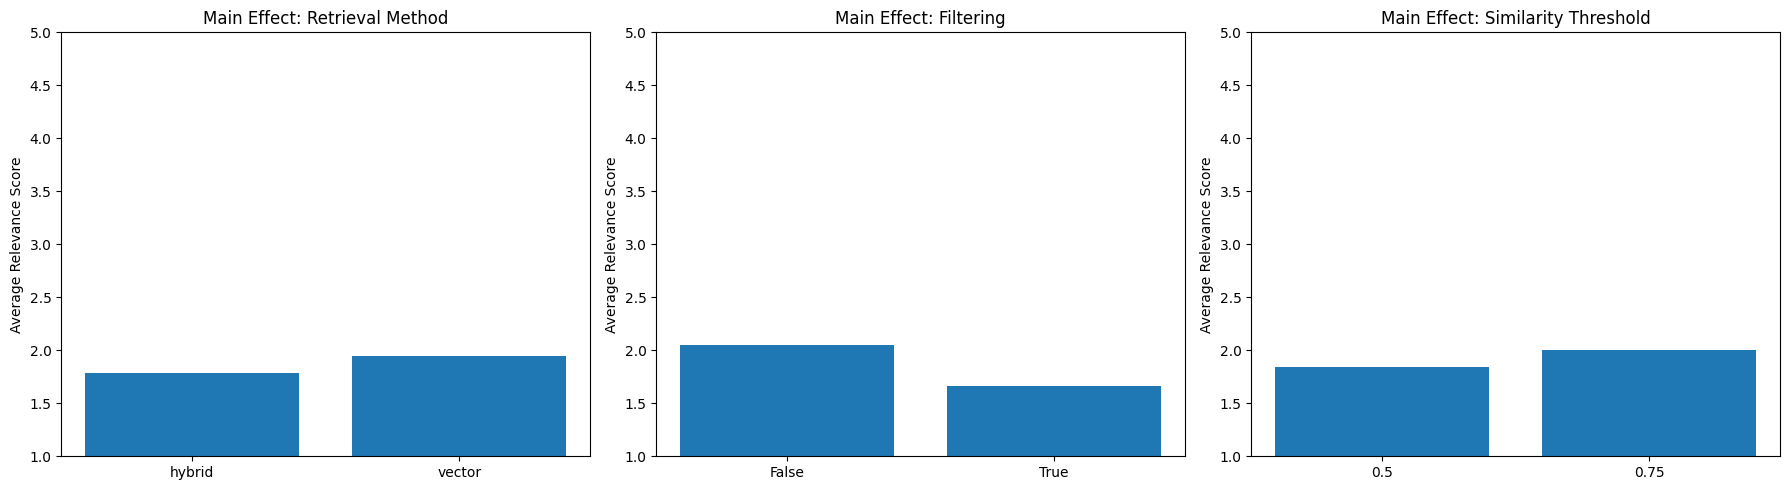

In [33]:
# Visualize main effects
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (factor, data) in enumerate(main_effects.items()):
    axes[i].bar(data.index.astype(str), data.values)
    axes[i].set_title(f"Main Effect: {factor}")
    axes[i].set_ylabel("Average Relevance Score")
    axes[i].set_ylim(1, 5)  # Set y-axis to score range

plt.tight_layout()
plt.savefig("main_effects.png")
plt.show()

In [34]:
# Calculate interaction effects
interactions = {
    "Retrieval × Filtering": all_results.groupby(["retrieval_method", "filtering"])["human_score"].mean().unstack(),
    "Retrieval × Threshold": all_results.groupby(["retrieval_method", "similarity_threshold"])["human_score"].mean().unstack(),
    "Filtering × Threshold": all_results.groupby(["filtering", "similarity_threshold"])["human_score"].mean().unstack()
}

# Show interaction effects
print("Interaction Effects (Average Score):")
for interaction, data in interactions.items():
    print(f"\n{interaction}:")
    print(data)

Interaction Effects (Average Score):

Retrieval × Filtering:
filtering         False     True 
retrieval_method                 
hybrid              1.9  1.666667
vector              2.2  1.666667

Retrieval × Threshold:
similarity_threshold    0.50  0.75
retrieval_method                  
hybrid                1.7500   2.0
vector                1.9375   2.0

Filtering × Threshold:
similarity_threshold    0.50  0.75
filtering                         
False                 2.0625   2.0
True                  1.6250   2.0


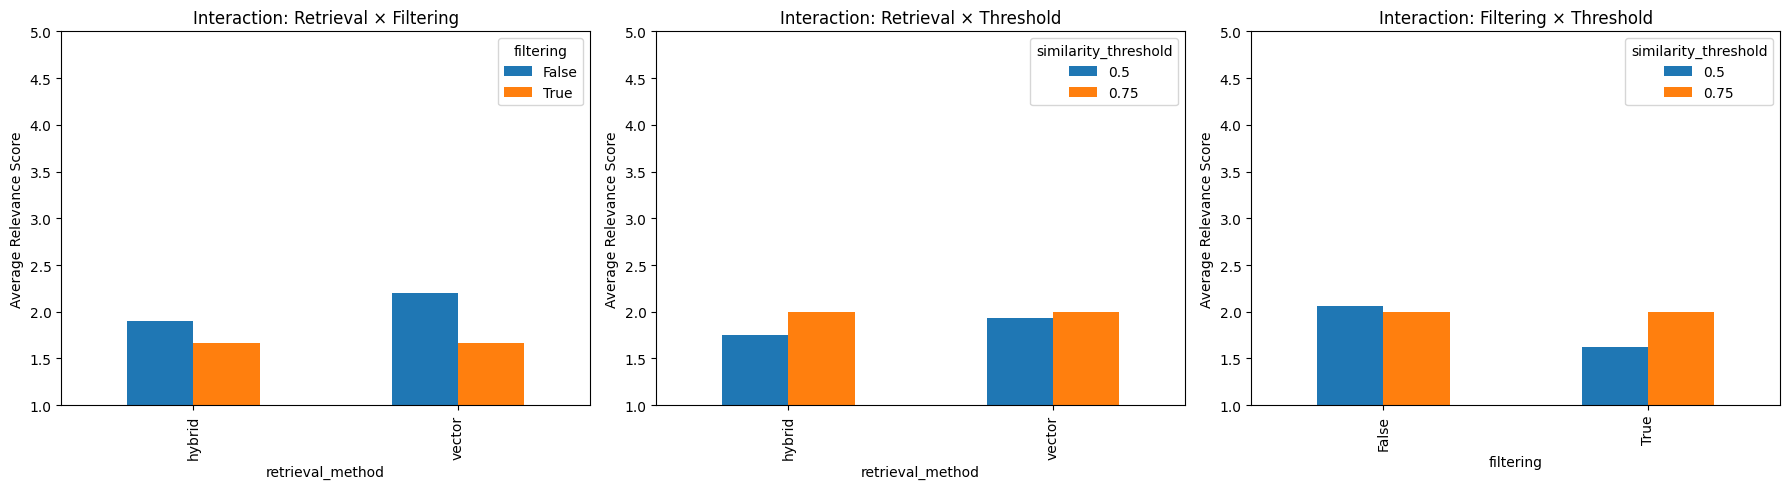

In [35]:
# Visualize interaction effects
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (interaction, data) in enumerate(interactions.items()):
    data.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"Interaction: {interaction}")
    axes[i].set_ylabel("Average Relevance Score")
    axes[i].set_ylim(1, 5)  # Set y-axis to score range

plt.tight_layout()
plt.savefig("interaction_effects.png")
plt.show()

## 11. Create Gold Dataset

Let's create a gold dataset with high-quality examples for future reference.

In [36]:
# Create Gold dataset (examples with score >= 4)
gold_dataset = all_results[all_results["human_score"] >= 4].copy()
gold_dataset["is_gold"] = True

# Print summary of Gold dataset
print(f"Gold Dataset contains {len(gold_dataset)} high-quality examples out of {len(all_results)} total.")
print(f"Distribution by factor:")
print(f"- Retrieval method: {gold_dataset['retrieval_method'].value_counts().to_dict()}")
print(f"- Filtering: {gold_dataset['filtering'].value_counts().to_dict()}")
print(f"- Similarity threshold: {gold_dataset['similarity_threshold'].value_counts().to_dict()}")

# Save Gold dataset for future experiments
gold_dataset.to_csv("rag_gold_dataset.csv", index=False)

Gold Dataset contains 1 high-quality examples out of 38 total.
Distribution by factor:
- Retrieval method: {'vector': 1}
- Filtering: {False: 1}
- Similarity threshold: {0.5: 1}


## 12. Summarize Findings

Let's summarize the key findings from our experiment.

In [37]:
# Identify best and worst conditions
condition_performance = all_results.groupby([
    "retrieval_method", "filtering", "similarity_threshold"
])["human_score"].mean().reset_index()

best_condition = condition_performance.loc[condition_performance["human_score"].idxmax()]
worst_condition = condition_performance.loc[condition_performance["human_score"].idxmin()]

print("Best performing condition:")
for col in best_condition.index:
    print(f"- {col}: {best_condition[col]}")

print("\nWorst performing condition:")
for col in worst_condition.index:
    print(f"- {col}: {worst_condition[col]}")

# Calculate overall factor importance
factor_importance = {}
for factor, effect in main_effects.items():
    factor_importance[factor] = effect.max() - effect.min()

print("\nFactor importance (range of effect):")
for factor, importance in sorted(factor_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"- {factor}: {importance:.2f}")

Best performing condition:
- retrieval_method: vector
- filtering: False
- similarity_threshold: 0.5
- human_score: 2.25

Worst performing condition:
- retrieval_method: hybrid
- filtering: True
- similarity_threshold: 0.5
- human_score: 1.625

Factor importance (range of effect):
- Filtering: 0.38
- Retrieval Method: 0.16
- Similarity Threshold: 0.16


## 13. Conclusion

In this notebook, we've:

1. Set up a RAG system using ChromaDB and OpenAI embeddings
2. Designed and executed a full factorial experiment to test retrieval factors
3. Analyzed the main effects and interactions between factors
4. Created a gold dataset with relevance justifications

The results help us understand which factors most significantly impact retrieval quality and provide guidance for optimizing our RAG system.